In [21]:
import vowpalwabbit
import random
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import itertools
import seaborn as sns
from celluloid import Camera

In [3]:
# VW tries to minimize loss/cost, therefore we will pass cost as -reward
USER_LIKED_ARTICLE = -1.0
USER_DISLIKED_ARTICLE = 0.0

In [4]:
def get_cost(context, action):
    if context["user"] == "Tom":
        if context["time_of_day"] == "morning" and action == "variant_3":
            return USER_LIKED_ARTICLE
        elif context["time_of_day"] == "afternoon" and action == "variant_3":
            return USER_LIKED_ARTICLE
        else:
            return USER_DISLIKED_ARTICLE
    elif context["user"] == "Anna":
        if context["time_of_day"] == "morning" and action == "variant_2":
            return USER_LIKED_ARTICLE
        elif context["time_of_day"] == "afternoon" and action == "variant_2":
            return USER_LIKED_ARTICLE
        else:
            return USER_DISLIKED_ARTICLE
        
    elif context["user"] == "Mike":
        if context["time_of_day"] == "morning" and action == "variant_3":
            return USER_LIKED_ARTICLE
        elif context["time_of_day"] == "afternoon" and action == "variant_5":
            return USER_LIKED_ARTICLE
        else:
            return USER_DISLIKED_ARTICLE

In [5]:
# This function modifies (context, action, cost, probability) to VW friendly format
def to_vw_example_format(context, actions, cb_label=None):
    if cb_label is not None:
        chosen_action, cost, prob = cb_label
    example_string = ""
    example_string += "shared |User user={} time_of_day={}\n".format(
        context["user"], context["time_of_day"]
    )
    for action in actions:
        if cb_label is not None and action == chosen_action:
            example_string += "0:{}:{} ".format(cost, prob)
        example_string += "|Action article={} \n".format(action)
    # Strip the last newline
    return example_string[:-1]

In [6]:
def sample_custom_pmf(pmf):
    total = sum(pmf)
    scale = 1 / total
    pmf = [x * scale for x in pmf]
    draw = random.random()
    sum_prob = 0.0
    for index, prob in enumerate(pmf):
        sum_prob += prob
        if sum_prob > draw:
            return index, prob

In [7]:
def get_action(vw, context, actions):
    vw_text_example = to_vw_example_format(context, actions)
    pmf = vw.predict(vw_text_example)
    chosen_action_index, prob = sample_custom_pmf(pmf)
    return actions[chosen_action_index], prob

In [8]:
users = ["Tom", "Anna", "Mike"]
times_of_day = ["morning", "afternoon"]
actions = ["variant_1", "variant_2", "variant_3", "variant_4", "variant_5"]


def choose_user(users):
    return random.choice(users)


def choose_time_of_day(times_of_day):
    return random.choice(times_of_day)


# display preference matrix
def get_preference_matrix(cost_fun):
    def expand_grid(data_dict):
        rows = itertools.product(*data_dict.values())
        return pd.DataFrame.from_records(rows, columns=data_dict.keys())

    df = expand_grid({"users": users, "times_of_day": times_of_day, "actions": actions})
    df["cost"] = df.apply(
        lambda r: cost_fun({"user": r[0], "time_of_day": r[1]}, r[2]), axis=1
    )

    return df.pivot_table(
        index=["users", "times_of_day"], columns="actions", values="cost"
    )


get_preference_matrix(get_cost)

/tmp/ipykernel_1781/1184562814.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  lambda r: cost_fun({"user": r[0], "time_of_day": r[1]}, r[2]), axis=1


actions             variant_1  variant_2  variant_3  variant_4  variant_5
users times_of_day                                                       
Anna  afternoon           0.0       -1.0        0.0        0.0        0.0
      morning             0.0       -1.0        0.0        0.0        0.0
Mike  afternoon           0.0        0.0        0.0        0.0       -1.0
      morning             0.0        0.0       -1.0        0.0        0.0
Tom   afternoon           0.0        0.0       -1.0        0.0        0.0
      morning             0.0        0.0       -1.0        0.0        0.0

In [9]:
def run_simulation(
    vw, num_iterations, users, times_of_day, actions, cost_function, do_learn=True
):
    cost_sum = 0.0
    ctr = []

    for i in range(1, num_iterations + 1):
        # 1. In each simulation choose a user
        user = choose_user(users)
        # 2. Choose time of day for a given user
        time_of_day = choose_time_of_day(times_of_day)

        # 3. Pass context to vw to get an action
        context = {"user": user, "time_of_day": time_of_day}
        action, prob = get_action(vw, context, actions)

        # 4. Get cost of the action we chose
        cost = cost_function(context, action)
        cost_sum += cost

        if do_learn:
            # 5. Inform VW of what happened so we can learn from it
            vw_format = vw.parse(
                to_vw_example_format(context, actions, (action, cost, prob)),
                vowpalwabbit.LabelType.CONTEXTUAL_BANDIT,
            )
            # 6. Learn
            vw.learn(vw_format)

        # We negate this so that on the plot instead of minimizing cost, we are maximizing reward
        ctr.append(-1 * cost_sum / i)

    return ctr

In [10]:
def plot_ctr(num_iterations, ctr):
    plt.plot(range(1, num_iterations + 1), ctr)
    plt.xlabel("num_iterations", fontsize=14)
    plt.ylabel("ctr", fontsize=14)
    plt.ylim([0, 1])

In [11]:
def get_cost_new1(context, action):
    if context["user"] == "Tom":
        if context["time_of_day"] == "morning" and action == "variant_3":
            return USER_LIKED_ARTICLE
        elif context["time_of_day"] == "afternoon" and action == "variant_3":
            return USER_LIKED_ARTICLE
        else:
            return USER_DISLIKED_ARTICLE
    elif context["user"] == "Anna":
        if context["time_of_day"] == "morning" and action == "variant_2":
            return USER_LIKED_ARTICLE
        elif context["time_of_day"] == "afternoon" and action == "variant_2":
            return USER_LIKED_ARTICLE
        else:
            return USER_DISLIKED_ARTICLE
        
    elif context["user"] == "Mike":
        if context["time_of_day"] == "morning" and action == "variant_3":
            return USER_LIKED_ARTICLE
        elif context["time_of_day"] == "afternoon" and action == "variant_5":
            return USER_LIKED_ARTICLE
        else:
            return USER_DISLIKED_ARTICLE

get_preference_matrix(get_cost_new1)

/tmp/ipykernel_1781/1184562814.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  lambda r: cost_fun({"user": r[0], "time_of_day": r[1]}, r[2]), axis=1


actions             variant_1  variant_2  variant_3  variant_4  variant_5
users times_of_day                                                       
Anna  afternoon           0.0       -1.0        0.0        0.0        0.0
      morning             0.0       -1.0        0.0        0.0        0.0
Mike  afternoon           0.0        0.0        0.0        0.0       -1.0
      morning             0.0        0.0       -1.0        0.0        0.0
Tom   afternoon           0.0        0.0       -1.0        0.0        0.0
      morning             0.0        0.0       -1.0        0.0        0.0

In [12]:

def run_simulation_multiple_cost_functions(
    vw, num_iterations, users, times_of_day, actions, cost_functions, do_learn=True
):
    output = []
    cost_sum = 0.0
    ctr = []

    start_counter = 1
    end_counter = start_counter + num_iterations
    for cost_function in cost_functions:
        for i in range(start_counter, end_counter):
            # 1. in each simulation choose a user
            user = choose_user(users)
            # 2. choose time of day for a given user
            time_of_day = choose_time_of_day(times_of_day)

            # Construct context based on chosen user and time of day
            context = {"user": user, "time_of_day": time_of_day}

            # 3. Use the get_action function we defined earlier
            action, prob = get_action(vw, context, actions)
            
            step = [context['user'], context["time_of_day"], action]
            
            # 4. Get cost of the action we chose
            cost = cost_function(context, action)
            cost_sum += cost

            if do_learn:
                # 5. Inform VW of what happened so we can learn from it
                vw_format = vw.parse(
                    to_vw_example_format(context, actions, (action, cost, prob)),
                    vowpalwabbit.LabelType.CONTEXTUAL_BANDIT,
                )
                # 6. Learn
                vw.learn(vw_format)

            # We negate this so that on the plot instead of minimizing cost, we are maximizing reward
            ctr.append(-1 * cost_sum / i)
            output.append(step)
        start_counter = end_counter
        end_counter = start_counter + num_iterations

    return ctr, output

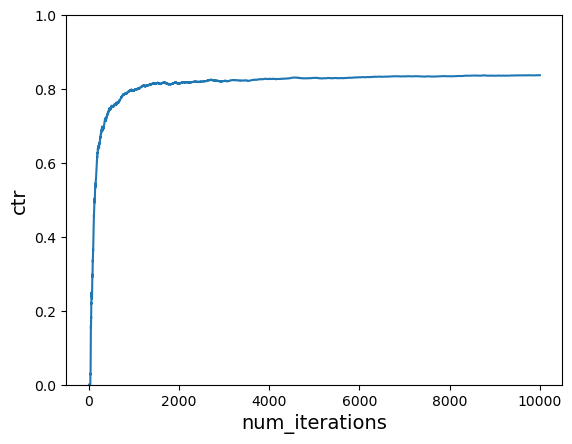

In [13]:
# use first reward function initially and then switch to second reward function

# Instantiate learner in VW
vw = vowpalwabbit.Workspace("--cb_explore_adf -q UA --quiet --epsilon 0.2")

num_iterations_per_cost_func = 5000
cost_functions = [get_cost, get_cost_new1]
total_iterations = num_iterations_per_cost_func * len(cost_functions)

ctr, output = run_simulation_multiple_cost_functions(
    vw, num_iterations_per_cost_func, users, times_of_day, actions, cost_functions
)

plot_ctr(total_iterations, ctr)

In [26]:
df

,time_step,Person,context,variant,psn_context_cumcnt,psn_cumcnt,max_actions_any1
0,0,Mike,morning,One,1,1,1
1,1,Anna,afternoon,Five,1,1,1
2,2,Mike,morning,One,2,2,2
3,3,Tom,afternoon,Two,1,1,2
4,4,Tom,morning,Four,1,2,2
...,...,...,...,...,...,...,...
9995,9995,Tom,morning,Three,1724,3382,3382
9996,9996,Anna,afternoon,Two,1651,3345,3382
9997,9997,Anna,afternoon,Two,1652,3346,3382
9998,9998,Mike,morning,Four,1661,3271,3382


In [57]:
df = pd.DataFrame(output, columns = ['Person', 'context', 'variant'])
variants = df.variant.drop_duplicates().values
df.reset_index(names=['time_step'], inplace=True)

cumcount = df.groupby(['Person', 'context'])['variant'].cumcount()+1
psn_cnt = df.groupby(['Person']).cumcount() +1
df['psn_context_cumcnt'] = cumcount
df['psn_cumcnt'] = psn_cnt

data =df#.query("psn_cumcnt == 100")
data['max_actions_any1'] = data['psn_cumcnt'].cummax()
rename_dict = {'variant_1':'One', 'variant_2':'Two', 'variant_3':'Three', 'variant_4':'Four', 'variant_5':'Five'}
data['variant'] = data['variant'].map(rename_dict)
data

,time_step,Person,context,variant,psn_context_cumcnt,psn_cumcnt,max_actions_any1
0,0,Mike,morning,One,1,1,1
1,1,Anna,afternoon,Five,1,1,1
2,2,Mike,morning,One,2,2,2
3,3,Tom,afternoon,Two,1,1,2
4,4,Tom,morning,Four,1,2,2
...,...,...,...,...,...,...,...
9995,9995,Tom,morning,Three,1724,3382,3382
9996,9996,Anna,afternoon,Two,1651,3345,3382
9997,9997,Anna,afternoon,Two,1652,3346,3382
9998,9998,Mike,morning,Four,1661,3271,3382


In [102]:

ls = []
for person in ['Tom', 'Anna', 'Mike']:
    for tod in ['morning', 'afternoon']:
            ls.append(tod + person)

locs = [1,4,2,5,3,6]
locs1 = [l-1 for l in locs]
loc_dict = dict(zip(ls, locs1))


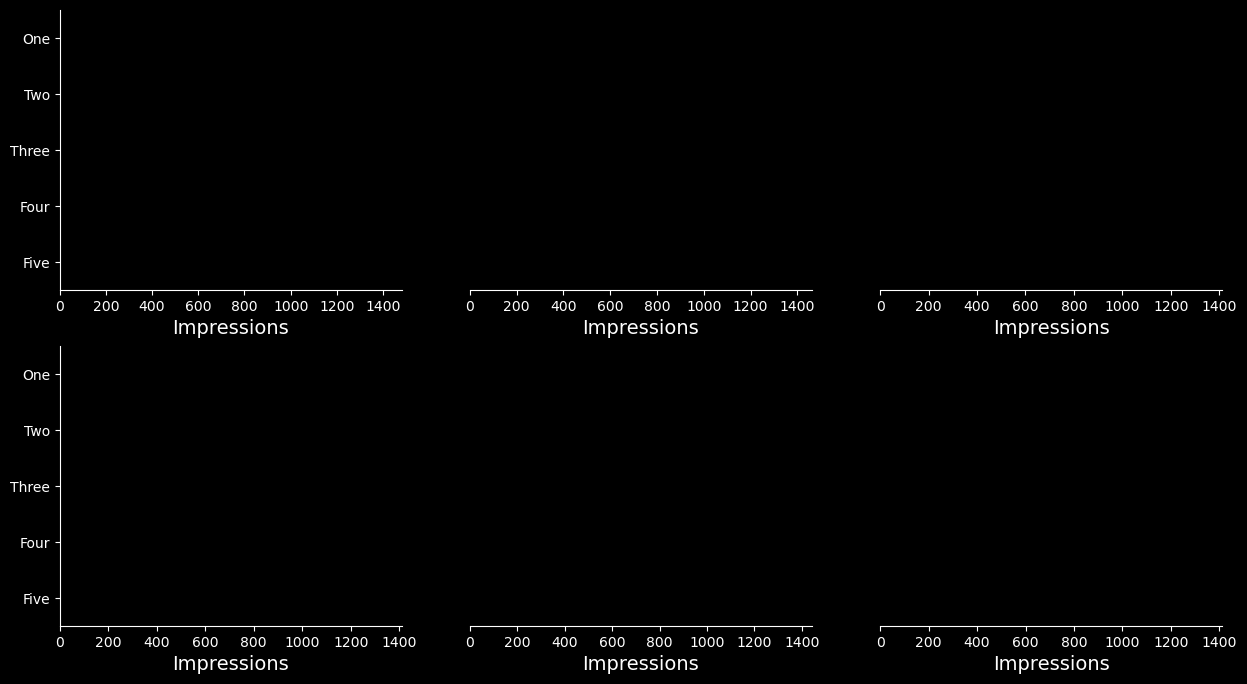

In [107]:
plt.style.use("dark_background")

colors = ['#023eff','#ff7c00','#1ac938','#e8000b', '#8b2be2']
order = ['One', 'Two', 'Three', 'Four', 'Five']
step_size =200


fig, axes =plt.subplots(nrows=2, ncols =3, figsize=(15, 8))

camera = Camera(fig)

for i in range(df.time_step.max()):
    if i % step_size == 0:
        
        pit = data.query("time_step <= @i").groupby(['Person' , 'context'])['variant'].value_counts().reset_index()
        
        for tod in ['morning', 'afternoon']:
                for person in ['Tom', 'Anna', 'Mike']:

                    loc = loc_dict[tod+person]
                    ax = axes.ravel()[loc]

                    sns.barplot(x="count", y="variant", data=pit.query('Person == @person & context == @tod'),
                             palette = colors, ax = axes.ravel()[loc], errorbar=None, order = order, width = 0.5)

                    ax.set_xlabel("Impressions")
                    ax.set_ylabel('', size=14)
                    if loc not in (0, 3):
                        ax.spines['left'].set_visible(False)
                        ax.set_yticklabels([])
                        ax.tick_params(axis='y', which='both', length=0)
                    ax.set_xlabel('Impressions', size=14)
                    ax.spines['top'].set_visible(False)
                    ax.spines['right'].set_visible(False)
                    
                 #   ax.set_title(tod+person, size=22)
                    
        camera.snap()
        
        
animation = camera.animate()
animation.save('cmab2.gif', writer = 'imagemagick')


/tmp/ipykernel_1781/1481005030.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="count", y="variant", data=pit.query('Person == "Mike"'),
/tmp/ipykernel_1781/1481005030.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="count", y="variant", data=pit.query('Person == "Tom"'),
/tmp/ipykernel_1781/1481005030.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="count", y="variant", data=pit.query('Person == "Anna"'),
/tmp/ipykernel_1781/1481005030.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and w

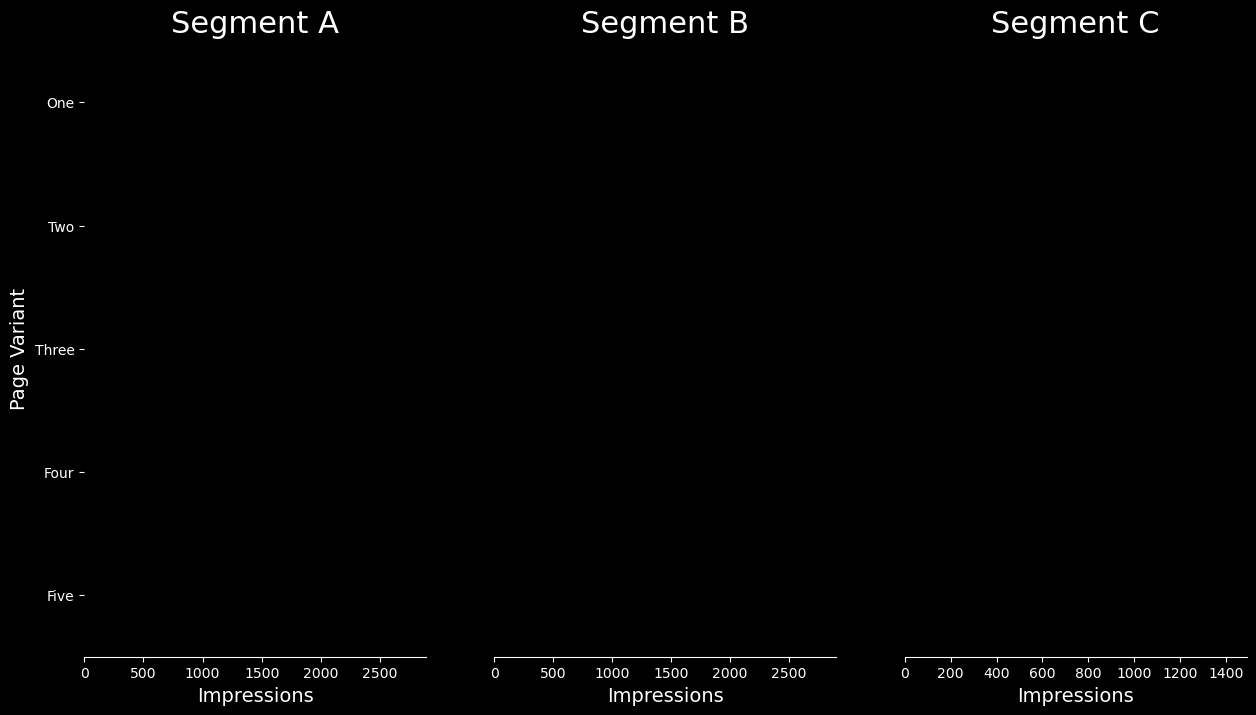

In [19]:

step_size =100
plt.style.use("dark_background")

colors = ['#023eff',
 '#ff7c00',
 '#1ac938',
 '#e8000b',
 '#8b2be2']


fig, (ax1, ax2, ax3) =plt.subplots(nrows=1, ncols =3, figsize=(15, 8))
camera = Camera(fig)

for i in range(df.time_step.max()):
    if i % step_size == 0:

        pit = data.query("time_step <= @i").groupby('Person')['variant'].value_counts().reset_index()

        plt.style.use("dark_background")
        # Set your custom color palette

        order = ['One', 'Two', 'Three', 'Four', 'Five']



        step_size =200


        sns.barplot(x="count", y="variant", data=pit.query('Person == "Tom"'),
                 palette = colors, ax = ax1, errorbar=None, order = order, width = 0.5)

        ax1.set_xlabel("Impressions")
        ax1.set_ylabel("Page Variant")
        ax1.set_ylabel('Page Variant', size=14)
        ax1.set_xlabel('Impressions', size=14)
        ax1.spines['top'].set_visible(False)
        ax1.spines['right'].set_visible(False)
        ax1.spines['left'].set_visible(False)
        ax1.set_title('Segment A', size=22)
        
        
        sns.barplot(x="count", y="variant", data=pit.query('Person == "Anna"'),
                 palette = colors,  ax = ax2, errorbar=None, order = order, width = 0.5 )

        ax2.set_xlabel("Impressions")
        ax2.set_ylabel('', size=14)
        ax2.set_xlabel('Impressions', size=14)
        ax2.spines['top'].set_visible(False)
        ax2.spines['right'].set_visible(False)
        ax2.spines['left'].set_visible(False)
        ax2.set_title('Segment B', size=22)
        ax2.set_yticklabels([])
        ax2.tick_params(axis='y', which='both', length=0)
        
        
        
        sns.barplot(x="count", y="variant", data=pit.query('Person == "Mike"'),
                 palette = colors,  ax = ax3, errorbar=None, order = order, width = 0.5 )

        ax3.set_xlabel("Impressions")
        ax3.set_ylabel('', size=14)
        ax3.set_xlabel('Impressions', size=14)
        ax3.spines['top'].set_visible(False)
        ax3.spines['right'].set_visible(False)
        ax3.spines['left'].set_visible(False)
        ax3.set_title('Segment C', size=22)
        ax3.set_yticklabels([])
        ax3.tick_params(axis='y', which='both', length=0)
        camera.snap()
        
        
animation = camera.animate()
animation.save('cmab1.gif', writer = 'imagemagick')



In [ ]:
pal = sns.color_palette('bright')
[i for i in pal.as_hex()]

In [ ]:
data0.query("max_actions_any1 == 100")